In [1]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

from scipy.stats import chi2
from scipy.special import erfinv

# import libraries:
import getdist
from getdist import plots, MCSamples
getdist.chains.print_load_details = False

import numpy as np
import git
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'../../..')))
# import tension tools utilities:
from tensiometer import utilities


def estimate_centroid_and_covariance(means, covariances):
    means = np.array(means)
    covariances = np.array(covariances)
    
    # Calculate the inverse of each covariance matrix
    inv_covariances = np.linalg.inv(covariances)
    
    # Calculate the weighted sum of the means
    weighted_means = np.einsum('ijk,ik->ij', inv_covariances, means)
    sum_inv_covariances = np.sum(inv_covariances, axis=0)
    
    # Calculate the centroid
    centroid = np.linalg.solve(sum_inv_covariances, np.sum(weighted_means, axis=0))
    
    # Calculate the covariance of the centroid
    centroid_covariance = np.linalg.inv(sum_inv_covariances)
    
    return centroid, centroid_covariance

2024-12-01 01:29:43.614341: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-01 01:29:44.045382: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-01 01:29:44.047546: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-01 01:29:45.650049: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Import cosmological data

In [2]:
# Create the two toy chains and the joint chain:
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
#os.chdir(os.path.join(path_git, 'source'))
os.chdir('/home/matias/montepython_public/output')

#Fixed Parameters
num_parameters = 2
num_datasets = 4

'''
A: CC 
B: Planck18 
C: BAO 
D: PPS
'''

chain_A = getdist.mcsamples.loadMCSamples(file_root='lcdm_cc/2023-09-18_1000000_', no_cache=True,settings={'loglikes':True,'label':'CC','ignore_rows': '0.3'})
chain_B = getdist.mcsamples.loadMCSamples(file_root='lcdm_planck/2023-09-16_1000000_', no_cache=True,settings={'loglikes':True,'label':'Planck18','ignore_rows': '0.3'})
chain_C = getdist.mcsamples.loadMCSamples(file_root='old_metrics/lcdm_bao_plus/2024-03-07_1000000_', no_cache=True,settings={'label':'BAO','ignore_rows': '0.3'})
chain_D = getdist.mcsamples.loadMCSamples(file_root='lcdm_pps/2023-09-18_1000000_', no_cache=True,settings={'label':'PPS','ignore_rows': '0.3'})

param_names = ['Omega_m','H0'] #Shared paameters

#Estimate the mean and covariance of the chains:
mean_A = chain_A.mean(param_names)
cov_A = chain_A.cov(param_names)
mean_B = chain_B.mean(param_names)
cov_B = chain_B.cov(param_names)
mean_C = chain_C.mean(param_names)
cov_C = chain_C.cov(param_names)
mean_D = chain_D.mean(param_names)
cov_D = chain_D.cov(param_names)

In [3]:
#Get the gaussian approximations
os.chdir(os.path.join(path_git))
from tensiometer import gaussian_tension
gaussian_A = gaussian_tension.gaussian_approximation(chain_A)
gaussian_B = gaussian_tension.gaussian_approximation(chain_B)
gaussian_C = gaussian_tension.gaussian_approximation(chain_C)
gaussian_D = gaussian_tension.gaussian_approximation(chain_D)

# Anova-like stimators

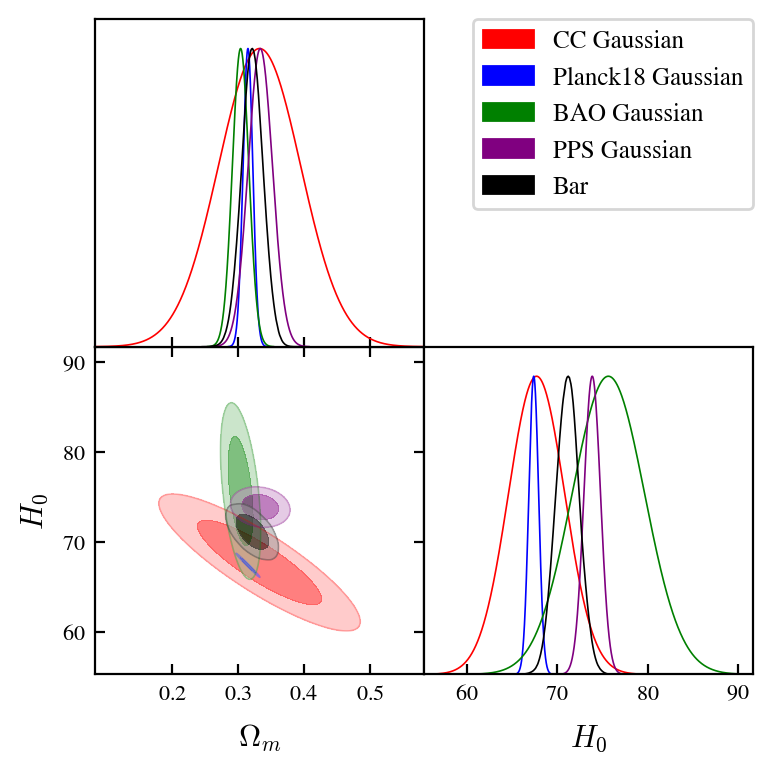

In [4]:
mean_bar = (mean_A + mean_B + mean_C + mean_D)/num_datasets
cov_tot = cov_A + cov_B + cov_C + cov_D
cov_bar = cov_tot / num_datasets**2

samps_bar = np.random.multivariate_normal(mean_bar, cov_bar, size=10000)
chain_bar = MCSamples(samples=samps_bar, names=param_names, labels=param_names, label='Bar')
colors = ['red', 'blue', 'green', 'purple', 'black']

g = plots.get_subplot_plotter()
g.triangle_plot([gaussian_A,gaussian_B,gaussian_C,gaussian_D, chain_bar], params=param_names,\
                legend_labels=['CC Gaussian','Planck18 Gaussian','BAO Gaussian','PPS Gaussian','Bar'],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors)
#g.export('figures_matrix_tension/contour_guassian.pdf')
plt.savefig('triangle_plot_data_mean.pdf')

delta_theta_A = mean_A - mean_bar
delta_theta_B = mean_B - mean_bar
delta_theta_C = mean_C - mean_bar
delta_theta_D = mean_D - mean_bar

## $\alpha$-stimator

\begin{equation}
    \alpha = \sum_{i} (\theta_i - \bar{\theta})^{T}  \frac{1}{\sum_{j} C_j}  (\theta_i - \bar{\theta})
\end{equation}

In [5]:
# Utility function to convert confidence level to sigma level
def from_confidence_to_sigma(confidence):
    return np.sqrt(2) * erfinv(confidence)

A_matrix = np.linalg.inv(cov_tot)

alpha = np.dot(delta_theta_A.T,np.dot(A_matrix, delta_theta_A)) \
      + np.dot(delta_theta_B.T,np.dot(A_matrix, delta_theta_B)) \
      + np.dot(delta_theta_C.T,np.dot(A_matrix, delta_theta_C)) \
      + np.dot(delta_theta_D.T,np.dot(A_matrix, delta_theta_D))

print(r'alpha: {}'.format(alpha))


# Compute the eigenvalues of (\Sigma * A)
A_eigenval = np.linalg.eigvals(np.dot(cov_A+cov_bar, A_matrix))
B_eigenval = np.linalg.eigvals(np.dot(cov_B+cov_bar, A_matrix))
C_eigenval = np.linalg.eigvals(np.dot(cov_C+cov_bar, A_matrix))
D_eigenval = np.linalg.eigvals(np.dot(cov_D+cov_bar, A_matrix))

coefficients = np.concatenate((A_eigenval, B_eigenval, C_eigenval, D_eigenval))
num_samples = int(1e6)
print(coefficients)

# Generate samples from chi-squared distributions with 1 degree of freedom
samples = np.random.chisquare(df=1, size=(num_samples, len(coefficients)))
print(samples.shape)
print(samples)
# Compute the weighted sum for each sample
weighted_sums = np.dot(samples, coefficients)
# Estimate the P-value
PTE = np.mean(weighted_sums >= alpha)
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:4g}'.format(n_sigma))


samp_chi2 = np.random.chisquare(df=1, size=num_samples) * (A_eigenval[0] + B_eigenval[0] + C_eigenval[0] + D_eigenval[0] + \
                                                        A_eigenval[1] + B_eigenval[1] + C_eigenval[1] + D_eigenval[1]) 

'''
samp_chi2 =(np.random.chisquare(df=1, size=num_samples) * A_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * B_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * C_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * D_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * A_eigenval[1] +\
            np.random.chisquare(df=1, size=num_samples) * B_eigenval[1] +\
            np.random.chisquare(df=1, size=num_samples) * C_eigenval[1] +\
            np.random.chisquare(df=1, size=num_samples) * D_eigenval[1])
'''

PTE = samp_chi2[samp_chi2 > alpha].size/samp_chi2.size
print('PTE: {}'.format(PTE))
#n_sigma = from_confidence_to_sigma(1-PTE)
n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:4g}'.format(n_sigma))


alpha: 2.8626682058427826
[0.93879692 0.19855688 0.07732195 0.06272429 0.09336588 0.85615381
 0.18126592 0.09181433]
(1000000, 8)
[[4.66550103e-01 3.66102700e-01 1.07384283e-03 ... 1.03066767e+00
  4.49167760e-02 3.95909663e-02]
 [1.33270106e-02 1.98770400e+00 2.59490983e-01 ... 3.93799319e+00
  2.96844620e-03 6.81573701e-01]
 [2.50398572e-01 3.95400798e+00 1.51302284e-01 ... 1.57690214e+00
  7.89378488e-01 1.36163830e+00]
 ...
 [5.70304671e-03 1.77648232e-01 1.38777846e+00 ... 6.15237174e-03
  6.33861979e-01 1.53634136e-01]
 [7.26932850e-01 1.41357424e-02 1.19678876e+00 ... 1.72573823e+00
  5.21009483e-01 1.16893765e+00]
 [2.86836541e+00 3.91970444e+00 9.15447898e-01 ... 1.43305501e-05
  1.89982015e-01 7.37259631e-02]]
PTE: 0.31126
n_sigma: 1.01258
PTE: 0.284992
n_sigma: 1.06917


## $\beta$-stimator

\begin{equation}
    \beta = \sum_{i,j} (\theta_i - \theta_j)^{T}  \frac{1}{C_{i}+C_{j}}  (\theta_i - \theta_j)
\end{equation}

In [6]:
beta = np.dot((mean_A - mean_B).T, np.dot(np.linalg.inv(cov_A + cov_B), (mean_A - mean_B))) \
     + np.dot((mean_A - mean_C).T, np.dot(np.linalg.inv(cov_A + cov_C), (mean_A - mean_C))) \
     + np.dot((mean_B - mean_C).T, np.dot(np.linalg.inv(cov_B + cov_C), (mean_B - mean_C))) \
     + np.dot((mean_A - mean_D).T, np.dot(np.linalg.inv(cov_A + cov_D), (mean_A - mean_D))) \
     + np.dot((mean_B - mean_D).T, np.dot(np.linalg.inv(cov_B + cov_D), (mean_B - mean_D))) \
     + np.dot((mean_C - mean_D).T, np.dot(np.linalg.inv(cov_C + cov_D), (mean_C - mean_D)))


print(r'beta: {}'.format(beta))

df=num_datasets*num_parameters
PTE = chi2.sf(beta, df)
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

samp_chi2 = np.random.chisquare(df=num_datasets*num_parameters, size=int(1e8))
PTE = samp_chi2[samp_chi2 > beta].size/samp_chi2.size
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

beta: 64.98853419215975
PTE: 4.85134489788294e-11
n_sigma: 6.57543
PTE: 0.0
n_sigma:   inf


In [7]:

'''
A: CC 
B: Planck18 
C: BAO 
D: PPS
'''
print(r'Diferentes términos de $\beta$:')
print('CC+Planck18:', np.dot((mean_A - mean_B).T, np.dot(np.linalg.inv(cov_A + cov_B), (mean_A - mean_B))))
print('CC+BAO:',np.dot((mean_A - mean_C).T, np.dot(np.linalg.inv(cov_A + cov_C), (mean_A - mean_C))))
print('Planck18+BAO:',np.dot((mean_B - mean_C).T, np.dot(np.linalg.inv(cov_B + cov_C), (mean_B - mean_C))))
print('CC+PPS:',np.dot((mean_A - mean_D).T, np.dot(np.linalg.inv(cov_A + cov_D), (mean_A - mean_D))))
print('Planck18+PPS:',np.dot((mean_B - mean_D).T, np.dot(np.linalg.inv(cov_B + cov_D), (mean_B - mean_D))))
print('BAO+PPS:',np.dot((mean_C - mean_D).T, np.dot(np.linalg.inv(cov_C + cov_D), (mean_C - mean_D))))

Diferentes términos de $\beta$:
CC+Planck18: 0.5381290661527516
CC+BAO: 2.7890147929266145
Planck18+BAO: 4.198605436052179
CC+PPS: 10.382340622752869
Planck18+PPS: 45.28306372417381
BAO+PPS: 1.7973805501015165


## $\gamma$-stimator

\begin{equation}
    \gamma = \sum_{i} (\theta_i - \bar{\theta})^{T}  \frac{1}{C_{i}}  (\theta_i - \bar{\theta})
\end{equation}

In [8]:
gamma = np.dot(delta_theta_A.T,np.dot(np.linalg.inv(cov_A), delta_theta_A)) \
      + np.dot(delta_theta_B.T,np.dot(np.linalg.inv(cov_B), delta_theta_B)) \
      + np.dot(delta_theta_C.T,np.dot(np.linalg.inv(cov_C), delta_theta_C)) \
      + np.dot(delta_theta_D.T,np.dot(np.linalg.inv(cov_D), delta_theta_D))

print(r'gamma: {}'.format(gamma))

# Compute the eigenvalues of (\Sigma * A)
A_eigenval = np.linalg.eigvals(np.dot(cov_A+cov_bar, A_matrix))
B_eigenval = np.linalg.eigvals(np.dot(cov_B+cov_bar, A_matrix))
C_eigenval = np.linalg.eigvals(np.dot(cov_C+cov_bar, A_matrix))
D_eigenval = np.linalg.eigvals(np.dot(cov_D+cov_bar, A_matrix))

coefficients = np.concatenate((A_eigenval, B_eigenval, C_eigenval, D_eigenval))
num_samples = int(1e6)
print(coefficients)

# Generate samples from chi-squared distributions with 1 degree of freedom
samples = np.random.chisquare(df=1, size=(num_samples, len(coefficients)))
print(samples.shape)
print(samples)
# Compute the weighted sum for each sample
weighted_sums = np.dot(samples, coefficients)
# Estimate the P-value
PTE = np.mean(weighted_sums >= gamma)
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))


samp_chi2 = np.random.chisquare(df=1, size=num_samples) * (A_eigenval[0] + B_eigenval[0] + C_eigenval[0] + D_eigenval[0] + \
                                                        A_eigenval[1] + B_eigenval[1] + C_eigenval[1] + D_eigenval[1]) 
'''
samp_chi2 =(np.random.chisquare(df=1, size=num_samples) * A_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * B_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * C_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * D_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * A_eigenval[1] +\
            np.random.chisquare(df=1, size=num_samples) * B_eigenval[1] +\
            np.random.chisquare(df=1, size=num_samples) * C_eigenval[1] +\
            np.random.chisquare(df=1, size=num_samples) * D_eigenval[1])
'''
PTE = samp_chi2[samp_chi2 >= gamma].size/samp_chi2.size
print('PTE: {}'.format(PTE))
#n_sigma = from_confidence_to_sigma(1-PTE)
n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

gamma: 3647.0880548640703
[0.93879692 0.19855688 0.07732195 0.06272429 0.09336588 0.85615381
 0.18126592 0.09181433]
(1000000, 8)
[[2.03835393 2.27960261 0.2150491  ... 0.38651001 1.84344357 0.87404654]
 [0.41487614 0.01941823 3.12537259 ... 1.09969999 1.67902172 0.11513547]
 [2.39590555 0.03432835 3.27311374 ... 0.89033922 0.12686835 0.00879175]
 ...
 [0.50956752 0.08757944 0.1499304  ... 3.09503044 0.31338635 1.00345021]
 [0.08232078 0.00621838 0.26188937 ... 0.00528013 0.02261989 0.2699475 ]
 [3.05332627 3.39235931 0.72670345 ... 1.40102361 0.83138879 0.11336471]]
PTE: 0.0
n_sigma:   inf
PTE: 0.0
n_sigma:   inf


In [9]:

'''
A: CC 
B: Planck18 
C: BAO 
D: PPS
'''
print(r'Diferentes términos de $\gamma$:')
print('CC:', np.dot(delta_theta_A.T,np.dot(np.linalg.inv(cov_A), delta_theta_A)))
print('Planck18:',np.dot(delta_theta_B.T,np.dot(np.linalg.inv(cov_B), delta_theta_B)))
print('BAO:',np.dot(delta_theta_C.T,np.dot(np.linalg.inv(cov_C), delta_theta_C)))
print('PPS:',np.dot(delta_theta_D.T,np.dot(np.linalg.inv(cov_D), delta_theta_D)))

Diferentes términos de $\gamma$:
CC: 3.5734978205169936
Planck18: 3631.318265217452
BAO: 2.246890479250802
PPS: 9.949401346850738


## $\delta$-stimator

\begin{equation}
    \delta = \sum_{i} (\theta_i - \bar{\theta})^{T}  \frac{1}{\bar{C}}  (\theta_i - \bar{\theta}) = n^{2} \cdot \alpha
\end{equation}

In [10]:
A_matrix = np.linalg.inv(cov_bar)

delta = np.dot(delta_theta_A.T,np.dot(A_matrix, delta_theta_A)) \
      + np.dot(delta_theta_B.T,np.dot(A_matrix, delta_theta_B)) \
      + np.dot(delta_theta_C.T,np.dot(A_matrix, delta_theta_C)) \
      + np.dot(delta_theta_D.T,np.dot(A_matrix, delta_theta_D))

# Compute the eigenvalues of (\Sigma * A)
A_eigenval = np.linalg.eigvals(np.dot(cov_A+cov_bar, A_matrix))
B_eigenval = np.linalg.eigvals(np.dot(cov_B+cov_bar, A_matrix))
C_eigenval = np.linalg.eigvals(np.dot(cov_C+cov_bar, A_matrix))
D_eigenval = np.linalg.eigvals(np.dot(cov_D+cov_bar, A_matrix))

coefficients = np.concatenate((A_eigenval, B_eigenval, C_eigenval, D_eigenval))
num_samples = int(1e6)
print(coefficients)

# Generate samples from chi-squared distributions with 1 degree of freedom
samples = np.random.chisquare(df=1, size=(num_samples, len(coefficients)))
print(samples.shape)
print(samples)
# Compute the weighted sum for each sample
weighted_sums = np.dot(samples, coefficients)
# Estimate the P-value
PTE = np.mean(weighted_sums >= delta)
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))


samp_chi2 = np.random.chisquare(df=1, size=num_samples) * (A_eigenval[0] + B_eigenval[0] + C_eigenval[0] + D_eigenval[0] + \
                                                        A_eigenval[1] + B_eigenval[1] + C_eigenval[1] + D_eigenval[1]) 

'''
samp_chi2 =(np.random.chisquare(df=1, size=num_samples) * A_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * B_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * C_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * D_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * A_eigenval[1] +\
            np.random.chisquare(df=1, size=num_samples) * B_eigenval[1] +\
            np.random.chisquare(df=1, size=num_samples) * C_eigenval[1] +\
            np.random.chisquare(df=1, size=num_samples) * D_eigenval[1])
'''


PTE = samp_chi2[samp_chi2 > delta].size/samp_chi2.size
print('PTE: {}'.format(PTE))
#n_sigma = from_confidence_to_sigma(1-PTE)
n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

[15.02075079  3.17691007  1.23715123  1.00358871  1.49385413 13.69846101
  2.90025472  1.46902934]


(1000000, 8)
[[1.20011928e+00 1.15271560e-01 7.63582331e+00 ... 4.45155872e-01
  1.33263100e-03 3.21805892e-01]
 [4.45339473e-01 1.94080969e+00 5.77963034e-02 ... 2.97508299e-01
  2.58827891e+00 1.07664912e+00]
 [4.72912304e-01 1.81218061e-01 5.70068600e-01 ... 4.20966378e-02
  9.07138236e-01 2.02504928e+00]
 ...
 [1.42714633e+00 5.16960635e-01 2.71150032e+00 ... 8.64915798e-01
  4.65967768e+00 2.70580119e-01]
 [1.63644027e+00 1.07711656e-01 1.78968478e+00 ... 1.70811606e+00
  4.82372494e-01 1.79202876e-01]
 [1.08904065e-01 1.14863438e+00 7.53695403e-01 ... 1.76262676e-01
  1.16904035e-01 4.89580309e-01]]
PTE: 0.310722
n_sigma: 1.01371
PTE: 0.284903
n_sigma: 1.06937


## $\epsilon$-stimator

\begin{equation}
    \epsilon = \sum_{i} (\theta_i - \bar{\theta})^{T}  \frac{1}{C_i + \bar{C}}  (\theta_i - \bar{\theta})
\end{equation}

In [11]:
epsilon = np.dot(delta_theta_A.T,np.dot(np.linalg.inv(cov_A + cov_bar), delta_theta_A)) \
        + np.dot(delta_theta_B.T,np.dot(np.linalg.inv(cov_B + cov_bar), delta_theta_B)) \
        + np.dot(delta_theta_C.T,np.dot(np.linalg.inv(cov_C + cov_bar), delta_theta_C)) \
        + np.dot(delta_theta_D.T,np.dot(np.linalg.inv(cov_D + cov_bar), delta_theta_D))

print(r'epsilon: {}'.format(epsilon))

df=num_datasets*num_parameters
PTE = chi2.sf(epsilon, df)
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

samp_chi2 = np.random.chisquare(df=num_datasets*num_parameters, size=int(1e8))
PTE = samp_chi2[samp_chi2 > epsilon].size/samp_chi2.size
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

epsilon: 22.365548118217664
PTE: 0.004281852138109138
n_sigma: 2.85661


PTE: 0.004281
n_sigma: 2.85668


# $Q_{DM}$

In [12]:
'''
A: CC 
B: Planck18 
C: BAO 
D: PPS
'''

Q_DM_AB = np.dot((mean_A - mean_B).T, np.dot(np.linalg.inv(cov_A + cov_B), (mean_A - mean_B)))
Q_DM_AC = np.dot((mean_A - mean_C).T, np.dot(np.linalg.inv(cov_A + cov_C), (mean_A - mean_C)))
Q_DM_BC = np.dot((mean_B - mean_C).T, np.dot(np.linalg.inv(cov_B + cov_C), (mean_B - mean_C)))
Q_DM_AD = np.dot((mean_A - mean_D).T, np.dot(np.linalg.inv(cov_A + cov_D), (mean_A - mean_D)))
Q_DM_BD = np.dot((mean_B - mean_D).T, np.dot(np.linalg.inv(cov_B + cov_D), (mean_B - mean_D)))
Q_DM_CD = np.dot((mean_C - mean_D).T, np.dot(np.linalg.inv(cov_C + cov_D), (mean_C - mean_D)))


df = num_parameters

PTE = chi2.sf(Q_DM_AB, df)
n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('PTE_AB: {}'.format(PTE))
print('n_sigma_AB: {:5g}'.format(n_sigma))

PTE = chi2.sf(Q_DM_AC, df)
n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('PTE_AC: {}'.format(PTE))
print('n_sigma_AC: {:5g}'.format(n_sigma))

PTE = chi2.sf(Q_DM_BC, df)
n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('PTE_BC: {}'.format(PTE))
print('n_sigma_BC: {:5g}'.format(n_sigma))

PTE = chi2.sf(Q_DM_AD, df)
n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('PTE_AB: {}'.format(PTE))
print('n_sigma_AB: {:5g}'.format(n_sigma))

PTE = chi2.sf(Q_DM_BD, df)
n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('PTE_AC: {}'.format(PTE))
print('n_sigma_AC: {:5g}'.format(n_sigma))

PTE = chi2.sf(Q_DM_CD, df)
n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('PTE_BC: {}'.format(PTE))
print('n_sigma_BC: {:5g}'.format(n_sigma))

PTE_AB: 0.7640939447242301
n_sigma_AB: 0.300109
PTE_AC: 0.24795514987175526
n_sigma_AC: 1.15533
PTE_BC: 0.12254184468920197
n_sigma_BC: 1.54419
PTE_AB: 0.00556548964625708
n_sigma_AB: 2.77234
PTE_AC: 1.4686139544364768e-10
n_sigma_AC: 6.4086
PTE_BC: 0.40710250303047246
n_sigma_BC: 0.829003
